# HW2

## GENERAL INSTRUCTIONS:

- CLEARLY mark where you are answering each question (all questions must be answered in Markdown cells, NOT as comments in code cells)
- Show all code necessary for the analysis, but remove superfluous code
- Check that your final PDF does not have code/markdown cutoff

---

Use the [Loan Dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv) on GitHub to build the classification models described below.

## Variable Descriptions:
- `age`: age in years of person.
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have.
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`.
- `income_in_k`: income in thousands of dollars.
- `state`: state person lives in.
- `credit_score`: credit score.
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
- `gave_loan`: whether or not the person got a loan.

## Instructions
1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan using all the other variables.*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training! see [here](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Extras/get_dummies.ipynb)).
    - use the `train_test_split()` to do an 80/20 split (make sure to use the SAME split when training all 3 models, do not re-split your data. We want each model to be trained on the same training set).
    - Appropriately z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using `GridSearchCV`.
    - For Decision Trees, use `GridSearchCV` to choose max_depth, and make sure to check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices for both train and test.
    
    
2. *Evaluate Your Models (WRITE YOUR ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy AND confusion matrices, **thoroughly discuss which model did best (if you had to pick one), how can you tell?**
    - B) **Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs?** (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased against/for certain gender groups).
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.**

# **1. Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan using all the other variables.**



In [13]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #model evaluation
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression # Logisitc Regression Model 
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import time
%matplotlib inline

In [14]:
#creating data frame
DF = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv")
DF.head()
#DF.shape

,age,had_cancer,gender_id,income_in_k,state,credit_score,num_credit_sources,utilization_rate,gave_loan
0,39,0,Female,54,TX,448,4,0.32,0
1,43,0,Female,66,NJ,399,4,0.35,0
2,42,0,Male,50,NE,509,8,0.23,0
3,46,0,Female,79,TX,540,6,0.15,0
4,43,0,Female,49,NV,485,10,0.20,0


*a) If a variable/predictor has more than 2 categories, use get_dummies() to convert them into dummy variables (don't forget to remove the original column when training! see here).*

In [15]:
#converting all variables with more than 2 categories into dummy variables
convertedDF = pd.get_dummies(DF, columns = ["state"])
convertedDF = pd.get_dummies(convertedDF, columns = ["gender_id"])
convertedDF

,age,had_cancer,income_in_k,credit_score,num_credit_sources,utilization_rate,gave_loan,state_AK,state_AL,state_AR,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,gender_id_Female,gender_id_Male,gender_id_Non-Binary,gender_id_Survey Choices Do Not Accurately Reflect My Identity
0,39,0,54,448,4,0.32,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,43,0,66,399,4,0.35,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,42,0,50,509,8,0.23,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,46,0,79,540,6,0.15,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,43,0,49,485,10,0.20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,42,0,59,493,3,0.16,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3996,44,0,66,659,11,0.36,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3997,42,0,71,630,3,0.61,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3998,38,0,62,822,5,0.23,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


*b) use the train_test_split() to do an 80/20 split (make sure to use the SAME split when training all 3 models, do not re-split your data. We want each model to be trained on the same training set).*

*c) Appropriately z-score your continuous variables only (interval data like age...etc can be counted as continuous)*

In [16]:
#z-score continuous vairables 
scaler = StandardScaler()
scaler.fit(convertedDF[['age', 'income_in_k', 'credit_score', 'utilization_rate']])
convertedDF[['age', 'income_in_k', 'credit_score', 'utilization_rate']] = scaler.transform(convertedDF[['age', 'income_in_k', 'credit_score', 'utilization_rate']])
convertedDF

,age,had_cancer,income_in_k,credit_score,num_credit_sources,utilization_rate,gave_loan,state_AK,state_AL,state_AR,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,gender_id_Female,gender_id_Male,gender_id_Non-Binary,gender_id_Survey Choices Do Not Accurately Reflect My Identity
0,-0.598138,0,-0.499822,-1.684047,4,0.765180,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.196796,0,0.239742,-2.138327,4,0.995442,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.001938,0,-0.746343,-1.118513,8,0.074394,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.792996,0,1.040936,-0.831111,6,-0.539638,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.196796,0,-0.807974,-1.341018,10,-0.155868,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.001938,0,-0.191670,-1.266850,3,-0.462884,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3996,0.395529,0,0.239742,0.272142,11,1.072196,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3997,-0.001938,0,0.547894,0.003282,3,2.991046,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3998,-0.796872,0,-0.006779,1.783321,5,0.074394,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
#train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(convertedDF.loc[:, convertedDF.columns != 'gave_loan'], convertedDF['gave_loan'])

In [18]:
#Logisitic Regression Model
modelLR = LogisticRegression()
modelLR.fit(Xtrain, ytrain)
modelLR.score(Xtest, ytest)

0.711

In [38]:
print(modelLR.score(Xtrain, ytrain))

0.7433333333333333


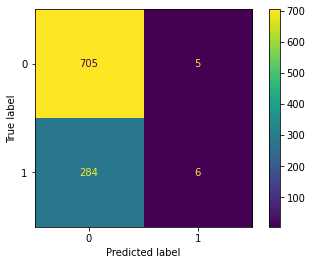

In [19]:
plot_confusion_matrix(modelLR, Xtest, ytest)

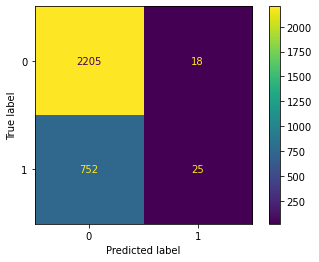

In [20]:
plot_confusion_matrix(modelLR, Xtrain, ytrain)

In [45]:
y_testpred = modelLR.predict(Xtest)
DF.iloc[Xtest.index].assign(y_testpred = y_testpred).groupby('gender_id').apply(lambda x:(x['gave_loan'] == x['y_testpred']).sum()/len(x))

gender_id
Female                                                  0.732143
Male                                                    0.684322
Non-Binary                                              0.818182
Survey Choices Do Not Accurately Reflect My Identity    0.769231
dtype: float64

*d) For KNN, include only continuous/interval columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than gave_loan).*

In [11]:
#K-Nearest Neighbors Model
modelKNN = KNeighborsClassifier()
parameters = {"n_neighbors": [2, 3, 4, 5]}
modelKNN = GridSearchCV(modelKNN, parameters)
modelKNN.fit(Xtrain, ytrain)
modelKNN.score(Xtrain, ytrain)
modelKNN.score(Xtest, ytest)

0.714

In [40]:
print(modelKNN.score(Xtrain, ytrain))

0.7656666666666667


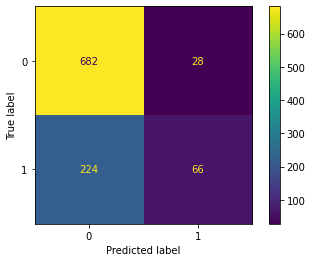

In [21]:
plot_confusion_matrix(modelKNN, Xtest, ytest)

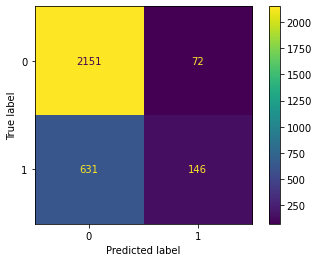

In [22]:
plot_confusion_matrix(modelKNN, Xtrain, ytrain)

In [44]:
y_testpred = modelKNN.predict(Xtest)
DF.iloc[Xtest.index].assign(y_testpred = y_testpred).groupby('gender_id').apply(lambda x:(x['gave_loan'] == x['y_testpred']).sum()/len(x))

gender_id
Female                                                  0.763889
Male                                                    0.733051
Non-Binary                                              0.818182
Survey Choices Do Not Accurately Reflect My Identity    0.615385
dtype: float64

*f) For Decision Trees, use GridSearchCV to choose max_depth, and make sure to check for overfitting.*

In [33]:
#Decision Tree Model
modelDT = DecisionTreeClassifier()
parameters = {"max_depth": [5,8,11,13]}
modelDT = GridSearchCV(modelDT, parameters)
modelDT.fit(Xtrain, ytrain)
trainscore = modelDT.score(Xtrain, ytrain)
testscore = modelDT.score(Xtest, ytest)
print(trainscore, testscore)

0.75 0.708


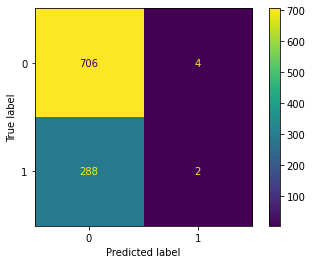

In [35]:
plot_confusion_matrix(modelDT, Xtest, ytest)

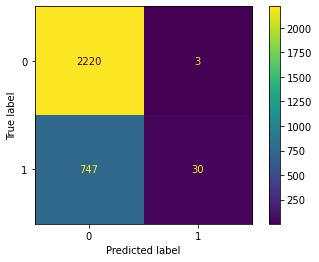

In [36]:
plot_confusion_matrix(modelDT, Xtrain, ytrain)

2b)

In [43]:
y_testpred = modelDT.predict(Xtest)
DF.iloc[Xtest.index].assign(y_testpred = y_testpred).groupby('gender_id').apply(lambda x:(x['gave_loan'] == x['y_testpred']).sum()/len(x))

gender_id
Female                                                  0.734127
Male                                                    0.675847
Non-Binary                                              0.818182
Survey Choices Do Not Accurately Reflect My Identity    0.769231
dtype: float64

# **2. Evaluate Your Models (WRITE YOUR ANSWER IN MARKDOWN CELL)**

*A) Using accuracy AND confusion matrices, thoroughly discuss which model did best (if you had to pick one), how can you tell?*

Using the accuracy and confusion matricies, the KNN model performed the best. The KNN Model provided the best accuracy scores for both training and testing data (.766, .714). For the Decision Tree Model, it has the worst accuracy score for testing data, but a better score for training data, indicating overfitting. When looking at the confusion matric for the Decision Tree, it produced a lot of False Negatives (288), and very rarely produced False Positives (4), meaning that the model is biased to guessing 0 (not recieve a loan). When looking at the KNN model confusion matrix, the ratio of True Positive to False Positive and ratio of True Negative and False Negative is much closer than the other models, indicating it is the best model as it does not assume everything is 0.

*B) Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs? (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased against/for certain gender groups).*

Yes there are differences in how accurate each of the 3 models are for different gender IDs. For the logistic regression and Decision Tree model, it produced a higher accuracy score for females. The KNN model produiced a fairly similar score for both males and females. Non-binary was consitently the highest gender accuracy score for each model.  

*C) Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.*

When looking at the confusion matrix for the Decision Tree, it is better at predicting for people who did not get loans, which is indicative by the large amount of false negatives, meaning it overestimated those that did not get loans. Out of the 290 people that did get loans, the model only correctly predicted 2 of them. Additionally, out of the 710 people who did not get loans, it correctly predicted that 4 of them got loans. When looking at the confusion matrix for KNN, it is also better at predicting those who did not get loans. Out of the 290 that did not get loans, it correctly predicted 66, which is better than the Decision Tree model, but still biased. The confusion matrix for the Logisitic Regression model says the same thing, but provides less accuracy than the KNN model (6 out of 290). The implications of this means that since there is more data for people who did not get loans, the models will all be more biased towards those who did not get them (overestimating that number). ASome real world applications would be that if people should get a loan, but the model says they shouldn't, that could really hurt them financially, and ultimately affect the banks credability. If it is not giving loans to people that should be getting them, no one will keep going to that bank.